Untuk dataset : https://drive.google.com/file/d/1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM/view?usp=sharing

fyi dataset yang ada di sini adalah dataset yang udah aku gabungin dari beberapa dataset yang ada di kaggle

dataset 1 : https://www.kaggle.com/datasets/nandanp6/cataract-image-dataset

dataset 2 : https://www.kaggle.com/datasets/akshayramakrishnan28/cataract-classification-dataset (full cataract)

dataset 3 : https://www.kaggle.com/datasets/himaniac/cataract-eye-dataset

Importing Dependencies

In [1]:
# Mengimpor Dependensi (contoh, Anda akan memiliki lebih banyak)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Contoh model pre-trained
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

import tensorflow as tf
def set_all_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Random seed diatur ke {seed}")

set_all_seeds(42)

Random seed diatur ke 42


In [3]:
!gdown --id 1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM
From (redirected): https://drive.google.com/uc?id=1eSAHIMOwanCxApF4oJWW5lG4HYdYz8NM&confirm=t&uuid=27efa825-0606-44a5-b3ba-fbfdc8f0d777
To: /content/dataset.zip
100% 553M/553M [00:03<00:00, 159MB/s]


In [4]:
!unzip dataset.zip

Archive:  dataset.zip
   creating: test/
   creating: test/cataract/
  inflating: test/cataract/image_246.png  
  inflating: test/cataract/image_247.png  
  inflating: test/cataract/image_248.png  
  inflating: test/cataract/image_249.png  
  inflating: test/cataract/image_250.png  
  inflating: test/cataract/image_251.png  
  inflating: test/cataract/image_252.png  
  inflating: test/cataract/image_253.png  
  inflating: test/cataract/image_254.png  
  inflating: test/cataract/image_255.png  
  inflating: test/cataract/image_256.png  
  inflating: test/cataract/image_257.png  
  inflating: test/cataract/image_258.png  
  inflating: test/cataract/image_259.png  
  inflating: test/cataract/image_260.png  
  inflating: test/cataract/image_261.png  
  inflating: test/cataract/image_262.png  
  inflating: test/cataract/image_263.png  
  inflating: test/cataract/image_264.png  
  inflating: test/cataract/image_265.png  
  inflating: test/cataract/image_266.png  
  inflating: test/cataract/i

In [5]:
# Hitung jumlah gambar
train_cataract = len(os.listdir("/content/train/cataract"))
train_normal = len(os.listdir("/content/train/normal"))
test_cataract = len(os.listdir("/content/test/cataract"))
test_normal = len(os.listdir("/content/test/normal"))

print(f"Train - Cataract: {train_cataract}, Normal: {train_normal}")
print(f"Test - Cataract: {test_cataract}, Normal: {test_normal}")


Train - Cataract: 874, Normal: 412
Test - Cataract: 61, Normal: 60


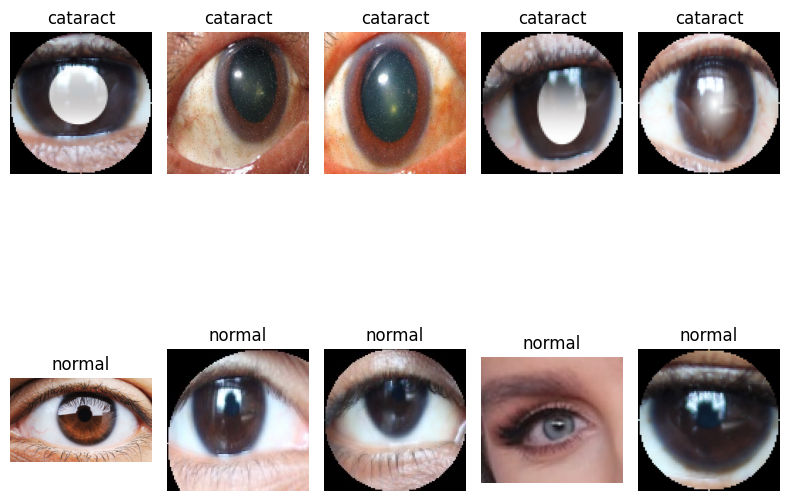

In [6]:
# Buat kamus berisi list nama file gambar per kelas
Prediction_image = {}
path = "/content/train"  # path ke folder train

for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        Prediction_image[class_name] = os.listdir(class_path)

# Tampilkan 2 gambar acak per kelas
num_classes = len(Prediction_image)
fig, axs = plt.subplots(num_classes, 5, figsize=(8, 4 * num_classes))

for i, (class_name, image_list) in enumerate(Prediction_image.items()):
    # ambil 2 gambar acak
    images = np.random.choice(image_list, 5, replace=False)
    for j, img_name in enumerate(images):
        img_path = os.path.join(path, class_name, img_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img,cmap='gray')  # atau hilangkan cmap='gray' untuk warna asli
        axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

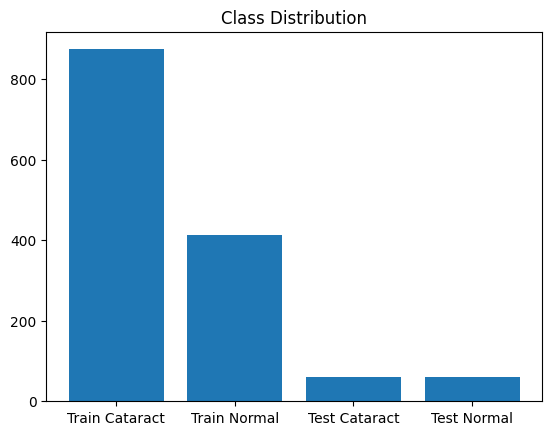

In [7]:
# Plot distribusi
plt.bar(["Train Cataract", "Train Normal", "Test Cataract", "Test Normal"],
        [train_cataract, train_normal, test_cataract, test_normal])
plt.title("Class Distribution")
plt.show()

Max Width: 5184, Min Width: 53
Max Height: 3456, Min Height: 53


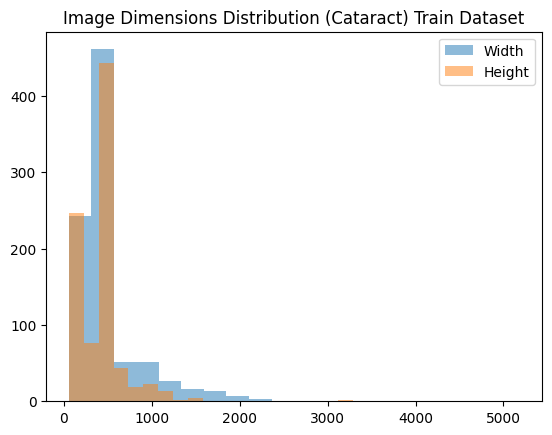

In [8]:
def analyze_image_stats(folder_path):
    widths, heights = [], []
    for img_file in os.listdir(folder_path):
        img = Image.open(os.path.join(folder_path, img_file))
        widths.append(img.width)
        heights.append(img.height)
    return widths, heights

widths, heights = analyze_image_stats("/content/train/cataract")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Cataract) Train Dataset")
plt.show()

Max Width: 5739, Min Width: 41
Max Height: 3826, Min Height: 36


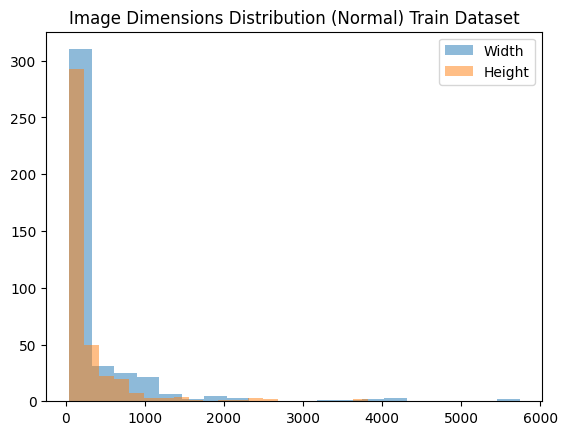

In [9]:
widths, heights = analyze_image_stats("/content/train/normal")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Normal) Train Dataset")
plt.show()

Max Width: 6622, Min Width: 200
Max Height: 3120, Min Height: 136


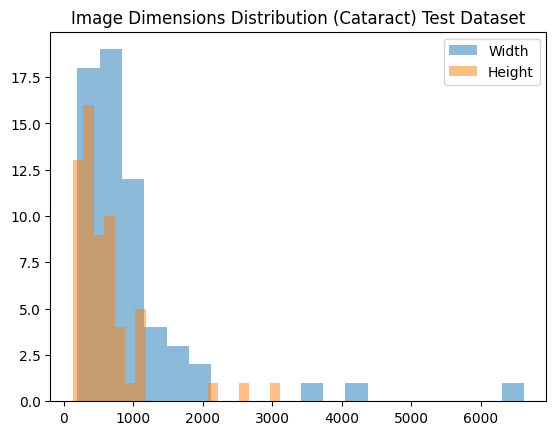

In [10]:
widths, heights = analyze_image_stats("/content/test/cataract")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Cataract) Test Dataset")
plt.show()

Max Width: 4220, Min Width: 69
Max Height: 2556, Min Height: 55


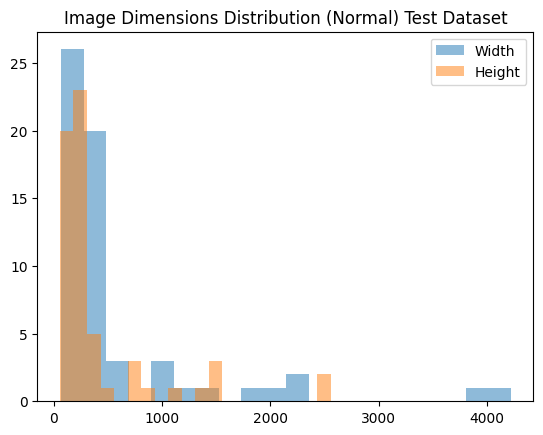

In [11]:
widths, heights = analyze_image_stats("/content/test/normal")
print(f"Max Width: {max(widths)}, Min Width: {min(widths)}")
print(f"Max Height: {max(heights)}, Min Height: {min(heights)}")

# Plot distribusi ukuran
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Dimensions Distribution (Normal) Test Dataset")
plt.show()

Preprocessing

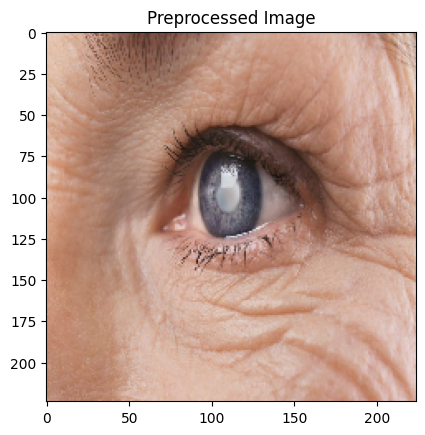

In [12]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalisasi [0, 1]
    return img

# Contoh preprocessing satu gambar
sample_img = preprocess_image("/content/train/cataract/image_155.png")
plt.imshow(sample_img)
plt.title("Preprocessed Image")
plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generator untuk data training
train_generator = train_datagen.flow_from_directory(
    "/content/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',  # Binary classification (cataract vs normal)
    shuffle=True
)

# Generator untuk data test (hanya normalisasi)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    "/content/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1286 images belonging to 2 classes.
Found 121 images belonging to 2 classes.


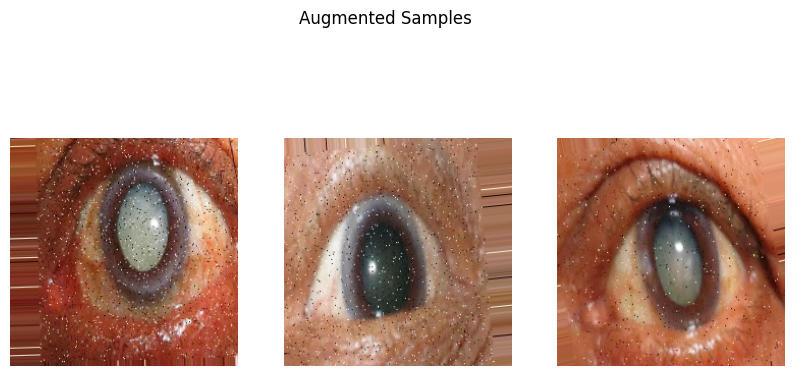

In [14]:
augmented_images, _ = next(train_generator)
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(augmented_images[i])
    plt.axis('off')
plt.suptitle("Augmented Samples")
plt.show()

In [15]:
print("Label Mapping:", train_generator.class_indices)
# Output harus: {'cataract': 0, 'normal': 1} atau sebaliknya

Label Mapping: {'cataract': 0, 'normal': 1}


In [16]:
import pandas as pd
from tqdm import tqdm

def save_preprocessed_data(generator, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    filenames, labels = [], []
    for i in tqdm(range(len(generator))):
        batch_x, batch_y = generator[i]
        for j in range(len(batch_x)):
            img_path = f"{save_dir}/img_{i}_{j}.png"
            cv2.imwrite(img_path, cv2.cvtColor(batch_x[j] * 255, cv2.COLOR_RGB2BGR))
            filenames.append(img_path)
            labels.append(batch_y[j])
    return pd.DataFrame({"filename": filenames, "label": labels})

# Contoh untuk train
df_train = save_preprocessed_data(train_generator, "/content/preprocessed_train")
df_train.to_csv("/content/train_metadata.csv", index=False)

100%|██████████| 41/41 [00:32<00:00,  1.26it/s]


# **Modelling**

In [17]:
#menggunakan callback jika data akurasi sudah 95%
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>0.95):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 # Import VGG16
from tensorflow.keras.optimizers import Adam # Import Adam

# Path ke data
train_dir = '/content/train'
test_dir  = '/content/test'

# Tentukan ukuran target gambar yang konsisten
image_target_size = (224, 224)

# Data generator (augmentasi hanya di train, rescale di kedua generator)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=40,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_target_size, # Ubah target_size menjadi 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_target_size, # Ubah target_size menjadi 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

def build_custom_model(num_classes, input_shape):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),

        GlobalAveragePooling2D(),  # Lebih stabil dibanding Flatten()
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



# (Optional) Callbacks: simpan best model dan early stopping
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
]

#VGG16
def build_vgg16_model(num_classes, input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape) # Menggunakan input_shape yang disesuaikan
    base_model.trainable = False  # Freeze weights

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#resnet50
def build_resnet50_model(num_classes, input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape) # Menggunakan input_shape yang disesuaikan
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Train model CNN custom
print("Training CNN Custom Model")
# Lewatkan input_shape ke fungsi pembangunan model
custom_model = build_custom_model(num_classes=train_generator.num_classes, input_shape=(224, 224, 3))
# Ringkasan arsitektur
custom_model.summary() # Ubah ini untuk mencetak ringkasan model custom

custom_history = custom_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

# Train model VGG16
print("Training VGG16 Model")
# Lewatkan input_shape ke fungsi pembangunan model
vgg_model = build_vgg16_model(num_classes=train_generator.num_classes, input_shape=(224, 224, 3))
vgg_history = vgg_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

# Train model ResNet50
print("Training ResNet50 Model")
# Lewatkan input_shape ke fungsi pembangunan model
resnet_model = build_resnet50_model(num_classes=train_generator.num_classes, input_shape=(224, 224, 3))
resnet_history = resnet_model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=callbacks
)

Found 1286 images belonging to 2 classes.
Found 121 images belonging to 2 classes.
Training CNN Custom Model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,018 (429.76 KB)

 Trainable params: 110,018 (429.76 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.6819 - loss: 0.6353

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 933ms/step - accuracy: 0.6818 - loss: 0.6352 - val_accuracy: 0.5041 - val_loss: 0.7751
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.6716 - loss: 0.5944

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 774ms/step - accuracy: 0.6718 - loss: 0.5940 - val_accuracy: 0.5041 - val_loss: 0.7474
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.6813 - loss: 0.5299

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 807ms/step - accuracy: 0.6814 - loss: 0.5301 - val_accuracy: 0.7273 - val_loss: 0.6848
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 773ms/step - accuracy: 0.7017 - loss: 0.5596 - val_accuracy: 0.5785 - val_loss: 0.7178
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 780ms/step - accuracy: 0.7251 - loss: 0.4960 - val_accuracy: 0.7190 - val_loss: 0.6918
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 795ms/step - accuracy: 0.7186 - loss: 0.4923 - val_accuracy: 0.6942 - val_loss: 0.6929
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 690ms/step - accuracy: 0.7370 - loss: 0.4782

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 781ms/step - accuracy: 0.7368 - loss: 0.4785 - val_accuracy: 0.7521 - val_loss: 0.6782
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.7681 - loss: 0.4563

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 778ms/step - accuracy: 0.7680 - loss: 0.4566 - val_accuracy: 0.7273 - val_loss: 0.6308
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - accuracy: 0.7361 - loss: 0.4664 - val_accuracy: 0.6446 - val_loss: 0.7310
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 801ms/step - accuracy: 0.7400 - loss: 0.4771 - val_accuracy: 0.6860 - val_loss: 0.7916
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7812 - loss: 0.4468

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 775ms/step - accuracy: 0.7813 - loss: 0.4465 - val_accuracy: 0.7273 - val_loss: 0.5858
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 759ms/step - accuracy: 0.7501 - loss: 0.4786 - val_accuracy: 0.7355 - val_loss: 0.6001
Epoch 13/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 785ms/step - accuracy: 0.7704 - loss: 0.4377 - val_accuracy: 0.7107 - val_loss: 0.5897
Epoch 14/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 777ms/step - accuracy: 0.8260 - loss: 0.3808 - val_accuracy: 0.7603 - val_loss: 0.5952
Epoch 15/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 785ms/step - accuracy: 0.8191 - loss: 0.4083 - val_accuracy: 0.7355 - val_loss: 0.6186
Epoch 16/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.8207 - loss: 0.3867

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 820ms/step - accuracy: 0.8212 - loss: 0.3862 - val_accuracy: 0.7521 - val_loss: 0.5729
Epoch 17/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.8298 - loss: 0.3652

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 768ms/step - accuracy: 0.8300 - loss: 0.3650 - val_accuracy: 0.7603 - val_loss: 0.5451
Epoch 18/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 780ms/step - accuracy: 0.8351 - loss: 0.3570 - val_accuracy: 0.7686 - val_loss: 0.5460
Epoch 19/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 797ms/step - accuracy: 0.8523 - loss: 0.3420 - val_accuracy: 0.7603 - val_loss: 0.5474
Epoch 20/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.8859 - loss: 0.3013

41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 779ms/step - accuracy: 0.8854 - loss: 0.3017 - val_accuracy: 0.8017 - val_loss: 0.5098
Epoch 21/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 803ms/step - accuracy: 0.8617 - loss: 0.3204 - val_accuracy: 0.7355 - val_loss: 0.5434
Epoch 22/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 806ms/step - accuracy: 0.8037 - loss: 0.4066 - val_accuracy: 0.7521 - val_loss: 0.5240
Epoch 23/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 761ms/step - accuracy: 0.8442 - loss: 0.3179 - val_accuracy: 0.7355 - val_loss: 0.5646
Epoch 24/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 784ms/step - accuracy: 0.8383 - loss: 0.3528 - val_accuracy: 0.7769 - val_loss: 0.5236
Epoch 25/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.8789 - loss: 0.2816

41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 765ms/step - accuracy: 0.8787 - loss: 0.2820 - val_accuracy: 0.7934 - val_loss: 0.4761
Epoch 26/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 789ms/step - accuracy: 0.8626 - loss: 0.2925 - val_accuracy: 0.7686 - val_loss: 0.5089
Epoch 27/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 761ms/step - accuracy: 0.8992 - loss: 0.2631 - val_accuracy: 0.7521 - val_loss: 0.7939
Epoch 28/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.8630 - loss: 0.3018

41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 776ms/step - accuracy: 0.8631 - loss: 0.3018 - val_accuracy: 0.8264 - val_loss: 0.4261
Epoch 29/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 776ms/step - accuracy: 0.8657 - loss: 0.3073 - val_accuracy: 0.7934 - val_loss: 0.4782
Epoch 30/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 31s 763ms/step - accuracy: 0.8817 - loss: 0.2652 - val_accuracy: 0.8099 - val_loss: 0.4386
Training VGG16 Model
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6272 - loss: 0.8769

41/41 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6293 - loss: 0.8710 - val_accuracy: 0.8760 - val_loss: 0.3002
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.8300 - loss: 0.3505

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 809ms/step - accuracy: 0.8301 - loss: 0.3503 - val_accuracy: 0.9008 - val_loss: 0.2604
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.8710 - loss: 0.2977

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - accuracy: 0.8708 - loss: 0.2977 - val_accuracy: 0.9174 - val_loss: 0.2407
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.8985 - loss: 0.2538

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 818ms/step - accuracy: 0.8981 - loss: 0.2541 - val_accuracy: 0.9174 - val_loss: 0.2245
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.8822 - loss: 0.2698

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 843ms/step - accuracy: 0.8822 - loss: 0.2696 - val_accuracy: 0.9174 - val_loss: 0.1952
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 819ms/step - accuracy: 0.8938 - loss: 0.2353 - val_accuracy: 0.9174 - val_loss: 0.2040
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.8831 - loss: 0.2550

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 818ms/step - accuracy: 0.8832 - loss: 0.2549 - val_accuracy: 0.9008 - val_loss: 0.1951
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9185 - loss: 0.1996

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 820ms/step - accuracy: 0.9182 - loss: 0.2001 - val_accuracy: 0.9174 - val_loss: 0.1889
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.8859 - loss: 0.2361

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 820ms/step - accuracy: 0.8864 - loss: 0.2355 - val_accuracy: 0.9339 - val_loss: 0.1633
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 823ms/step - accuracy: 0.9087 - loss: 0.2152 - val_accuracy: 0.9339 - val_loss: 0.1874
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.9263 - loss: 0.1907

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - accuracy: 0.9264 - loss: 0.1904 - val_accuracy: 0.9091 - val_loss: 0.1604
Epoch 12/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 828ms/step - accuracy: 0.9071 - loss: 0.2269 - val_accuracy: 0.9421 - val_loss: 0.1859
Epoch 13/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 813ms/step - accuracy: 0.9227 - loss: 0.1882 - val_accuracy: 0.9339 - val_loss: 0.1617
Epoch 14/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 828ms/step - accuracy: 0.9322 - loss: 0.1830 - val_accuracy: 0.9091 - val_loss: 0.1614
Epoch 15/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 35s 849ms/step - accuracy: 0.9267 - loss: 0.1875 - val_accuracy: 0.9421 - val_loss: 0.1876
Epoch 16/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.9032 - loss: 0.1990

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 824ms/step - accuracy: 0.9035 - loss: 0.1987 - val_accuracy: 0.9421 - val_loss: 0.1468
Epoch 17/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.9100 - loss: 0.1831

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 830ms/step - accuracy: 0.9101 - loss: 0.1830 - val_accuracy: 0.9256 - val_loss: 0.1426
Epoch 18/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 824ms/step - accuracy: 0.9317 - loss: 0.1738 - val_accuracy: 0.9504 - val_loss: 0.1439
Epoch 19/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9186 - loss: 0.1787

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 819ms/step - accuracy: 0.9188 - loss: 0.1784 - val_accuracy: 0.9421 - val_loss: 0.1266
Epoch 20/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 822ms/step - accuracy: 0.9319 - loss: 0.1759 - val_accuracy: 0.9587 - val_loss: 0.1344
Epoch 21/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9402 - loss: 0.1350

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 831ms/step - accuracy: 0.9401 - loss: 0.1352 - val_accuracy: 0.9421 - val_loss: 0.1170
Epoch 22/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 809ms/step - accuracy: 0.9438 - loss: 0.1409 - val_accuracy: 0.9421 - val_loss: 0.1268
Epoch 23/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 811ms/step - accuracy: 0.9408 - loss: 0.1473 - val_accuracy: 0.9504 - val_loss: 0.1241
Epoch 24/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 843ms/step - accuracy: 0.9525 - loss: 0.1394 - val_accuracy: 0.9421 - val_loss: 0.1204
Epoch 25/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.9338 - loss: 0.1611

41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 803ms/step - accuracy: 0.9337 - loss: 0.1611 - val_accuracy: 0.9256 - val_loss: 0.1166
Epoch 26/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 827ms/step - accuracy: 0.9495 - loss: 0.1354 - val_accuracy: 0.9421 - val_loss: 0.1176
Epoch 27/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.9446 - loss: 0.1398

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 831ms/step - accuracy: 0.9444 - loss: 0.1401 - val_accuracy: 0.9421 - val_loss: 0.1102
Epoch 28/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 810ms/step - accuracy: 0.9472 - loss: 0.1312 - val_accuracy: 0.9587 - val_loss: 0.1115
Epoch 29/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.9488 - loss: 0.1450

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 816ms/step - accuracy: 0.9489 - loss: 0.1448 - val_accuracy: 0.9587 - val_loss: 0.1096
Epoch 30/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 828ms/step - accuracy: 0.9291 - loss: 0.1487 - val_accuracy: 0.9339 - val_loss: 0.1413
Training ResNet50 Model
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5635 - loss: 1.5812 - val_accuracy: 0.5041 - val_loss: 0.7333
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 809ms/step - accuracy: 0.6831 - loss: 0.6244 - val_accuracy: 0.5041 - val_loss: 0.7238
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 822ms/step - accuracy: 0.6492 - loss: 0.6377 - val_accuracy: 0.5041 - val_loss: 0.8464
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 799ms/step - accuracy: 0.6703 - loss: 0.6402 - val_accuracy: 0.5041 - val_loss: 0.7158
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 825ms/step - accuracy: 0.6728 - loss: 0.6255 - val_accuracy: 0.5041 - val_loss: 0.6851
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━

# **Evaluasi dan Visualisasi**

In [26]:
models = {
    'Custom CNN': custom_model,
    'VGG16': vgg_model,
    'ResNet50': resnet_model
}

for name, model in models.items():
    loss, acc = model.evaluate(test_generator, verbose=0)
    print(f"{name} Test Accuracy: {acc:.2%}")


Custom CNN Test Accuracy: 82.64%
VGG16 Test Accuracy: 95.87%
ResNet50 Test Accuracy: 50.41%


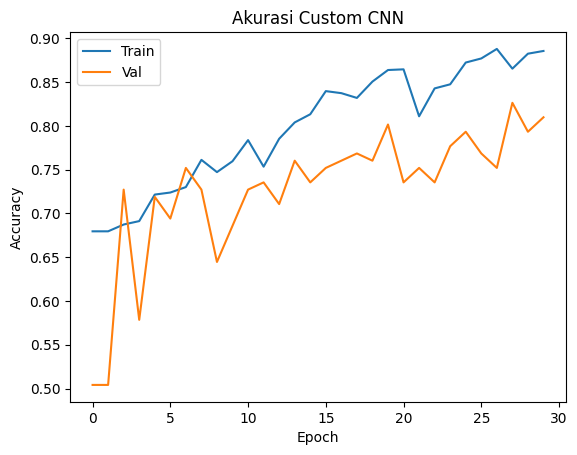

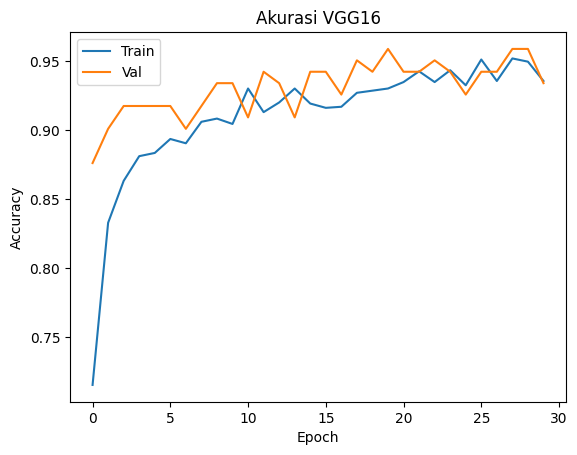

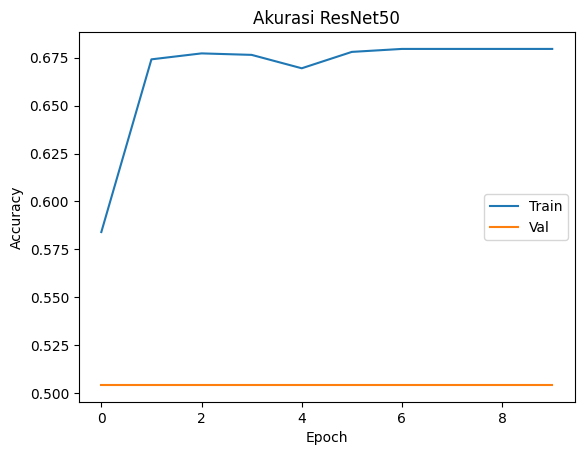

In [27]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'Akurasi {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(custom_history, "Custom CNN")
plot_history(vgg_history, "VGG16")
plot_history(resnet_history, "ResNet50")
